<a href="https://colab.research.google.com/github/P2Enjoy/ia-web3.fr/blob/main/Photomaton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

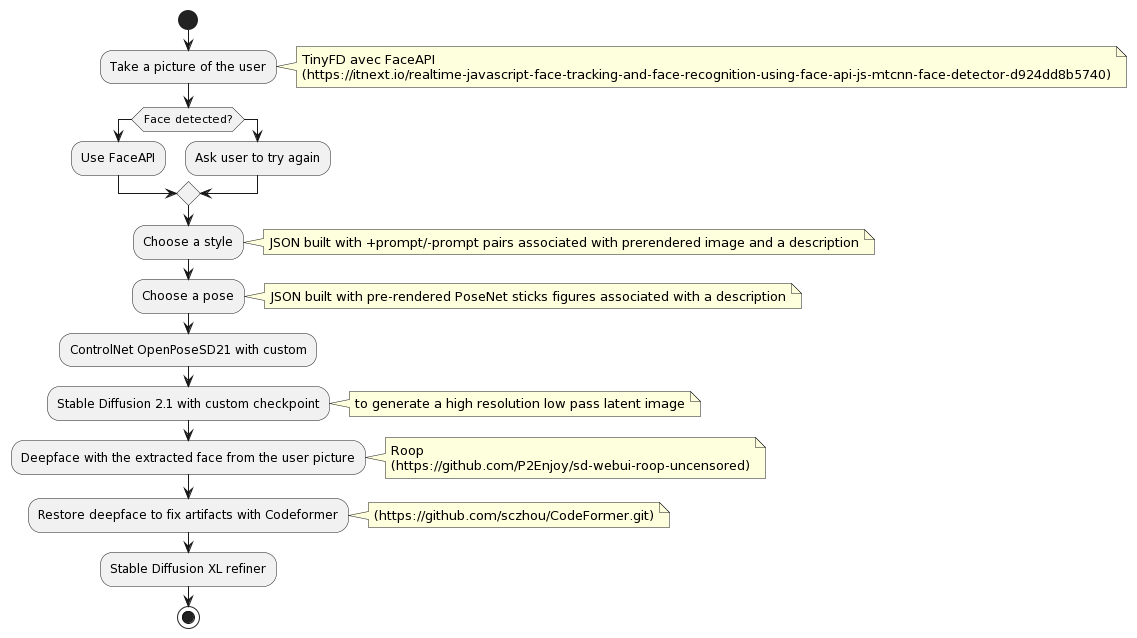

# Install Stable Diffusion

In [ ]:
import locale

locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
%%shell

# SD
pip install accelerate==0.22.0 diffusers==0.20.2 gradio==3.39.0 Pillow==10.0.0 torch==2.0.1 transformers==4.33.0 xformers==0.0.21 insightface==0.7.3 controlnet_aux==0.0.6 invisible-watermark==0.2.0

# Install Codeformer

In [ ]:
%%shell

# Sources
git clone https://github.com/sczhou/CodeFormer.git
# Set up the environment
cd CodeFormer
# Install python dependencies
pip install -r requirements.txt
# Install basicsr
python basicsr/setup.py develop

In [ ]:
import sys
sys.path.append('CodeFormer')
import os
import cv2
import torch
import torch.nn.functional as F

from torchvision.transforms.functional import normalize

from basicsr.utils import imwrite, img2tensor, tensor2img
from basicsr.utils.download_util import load_file_from_url
from facelib.utils.face_restoration_helper import FaceRestoreHelper
from facelib.utils.misc import is_gray
from basicsr.archs.rrdbnet_arch import RRDBNet
from basicsr.utils.realesrgan_utils import RealESRGANer

from basicsr.utils.registry import ARCH_REGISTRY

pretrain_model_url = {
    'codeformer': 'https://github.com/sczhou/CodeFormer/releases/download/v0.1.0/codeformer.pth',
    'detection': 'https://github.com/sczhou/CodeFormer/releases/download/v0.1.0/detection_Resnet50_Final.pth',
    'parsing': 'https://github.com/sczhou/CodeFormer/releases/download/v0.1.0/parsing_parsenet.pth',
    'realesrgan': 'https://github.com/sczhou/CodeFormer/releases/download/v0.1.0/RealESRGAN_x2plus.pth'
}
# download weights
if not os.path.exists('CodeFormer/weights/CodeFormer/codeformer.pth'):
    load_file_from_url(url=pretrain_model_url['codeformer'], model_dir='CodeFormer/weights/CodeFormer', progress=True, file_name=None)
if not os.path.exists('CodeFormer/weights/facelib/detection_Resnet50_Final.pth'):
    load_file_from_url(url=pretrain_model_url['detection'], model_dir='CodeFormer/weights/facelib', progress=True, file_name=None)
if not os.path.exists('CodeFormer/weights/facelib/parsing_parsenet.pth'):
    load_file_from_url(url=pretrain_model_url['parsing'], model_dir='CodeFormer/weights/facelib', progress=True, file_name=None)
if not os.path.exists('CodeFormer/weights/realesrgan/RealESRGAN_x2plus.pth'):
    load_file_from_url(url=pretrain_model_url['realesrgan'], model_dir='CodeFormer/weights/realesrgan', progress=True, file_name=None)

In [ ]:
# set enhancer with RealESRGAN
def set_realesrgan():
    half = True if torch.cuda.is_available() else False
    model = RRDBNet(
        num_in_ch=3,
        num_out_ch=3,
        num_feat=64,
        num_block=23,
        num_grow_ch=32,
        scale=2,
    )
    upsampler = RealESRGANer(
        scale=2,
        model_path="CodeFormer/weights/realesrgan/RealESRGAN_x2plus.pth",
        model=model,
        tile=400,
        tile_pad=40,
        pre_pad=0,
        half=half,
    )
    return upsampler

upsampler = set_realesrgan()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
codeformer_net = ARCH_REGISTRY.get("CodeFormer")(
    dim_embd=512,
    codebook_size=1024,
    n_head=8,
    n_layers=9,
    connect_list=["32", "64", "128", "256"],
).to(device)
ckpt_path = "CodeFormer/weights/CodeFormer/codeformer.pth"
checkpoint = torch.load(ckpt_path)["params_ema"]
codeformer_net.load_state_dict(checkpoint)
codeformer_net.eval()

In [ ]:
def codeformer(image, face_align, background_enhance, face_upsample, upscale, codeformer_fidelity):
    """Run a single prediction on the model"""
    try: # global try
        # take the default setting for the demo
        only_center_face = False
        draw_box = False
        detection_model = "retinaface_resnet50"

        print('Inp:', image, background_enhance, face_upsample, upscale, codeformer_fidelity)
        face_align = face_align if face_align is not None else True
        background_enhance = background_enhance if background_enhance is not None else True
        face_upsample = face_upsample if face_upsample is not None else True
        upscale = upscale if (upscale is not None and upscale > 0) else 2

        has_aligned = not face_align
        upscale = 1 if has_aligned else upscale

        img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        print('\timage size:', img.shape)

        upscale = int(upscale) # convert type to int
        if upscale > 4: # avoid memory exceeded due to too large upscale
            upscale = 4
        if upscale > 2 and max(img.shape[:2])>1000: # avoid memory exceeded due to too large img resolution
            upscale = 2
        if max(img.shape[:2]) > 1500: # avoid memory exceeded due to too large img resolution
            upscale = 1
            background_enhance = False
            face_upsample = False

        face_helper = FaceRestoreHelper(
            upscale,
            face_size=512,
            crop_ratio=(1, 1),
            det_model=detection_model,
            save_ext="png",
            use_parse=True,
            device=device,
        )
        bg_upsampler = upsampler if background_enhance else None
        face_upsampler = upsampler if face_upsample else None

        if has_aligned:
            # the input faces are already cropped and aligned
            img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_LINEAR)
            face_helper.is_gray = is_gray(img, threshold=5)
            if face_helper.is_gray:
                print('\tgrayscale input: True')
            face_helper.cropped_faces = [img]
        else:
            face_helper.read_image(img)
            # get face landmarks for each face
            num_det_faces = face_helper.get_face_landmarks_5(
              only_center_face=only_center_face, resize=640, eye_dist_threshold=5
            )
            print(f'\tdetect {num_det_faces} faces')
            # align and warp each face
            face_helper.align_warp_face()

        # face restoration for each cropped face
        for idx, cropped_face in enumerate(face_helper.cropped_faces):
            # prepare data
            cropped_face_t = img2tensor(
                cropped_face / 255.0, bgr2rgb=True, float32=True
            )
            normalize(cropped_face_t, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
            cropped_face_t = cropped_face_t.unsqueeze(0).to(device)

            try:
                with torch.no_grad():
                    output = codeformer_net(
                        cropped_face_t, w=codeformer_fidelity, adain=True
                    )[0]
                    restored_face = tensor2img(output, rgb2bgr=True, min_max=(-1, 1))
                del output
                torch.cuda.empty_cache()
            except RuntimeError as error:
                print(f"Failed inference for CodeFormer: {error}")
                restored_face = tensor2img(
                    cropped_face_t, rgb2bgr=True, min_max=(-1, 1)
                )

            restored_face = restored_face.astype("uint8")
            face_helper.add_restored_face(restored_face)

        # paste_back
        if not has_aligned:
            # upsample the background
            if bg_upsampler is not None:
                # Now only support RealESRGAN for upsampling background
                bg_img = bg_upsampler.enhance(img, outscale=upscale)[0]
            else:
                bg_img = None
            face_helper.get_inverse_affine(None)
            # paste each restored face to the input image
            if face_upsample and face_upsampler is not None:
                restored_img = face_helper.paste_faces_to_input_image(
                    upsample_img=bg_img,
                    draw_box=draw_box,
                    face_upsampler=face_upsampler,
                )
            else:
                restored_img = face_helper.paste_faces_to_input_image(
                    upsample_img=bg_img, draw_box=draw_box
                )
        else:
            restored_img = restored_face

        # save restored img
        save_path = f'output/out.png'
        imwrite(restored_img, str(save_path))

        restored_img = cv2.cvtColor(restored_img, cv2.COLOR_BGR2RGB)
        return PIL.Image.fromarray(restored_img)
    except Exception as error:
        print('Global exception', error)
        return None, None

# Install Roop

In [ ]:
%%shell

pip install insightface==0.7.3 onnx==1.14.0 onnxruntime==1.15.0

In [ ]:
import os

models_dir = os.path.abspath("models/onnx")
model_url = "https://github.com/P2Enjoy/ia-web3.fr/releases/download/onnx_checkpoint/model.onnx"
model_name = os.path.basename(model_url)
model_path = os.path.join(models_dir, model_name)

In [ ]:
from tqdm import tqdm
import urllib.request


def download(url, path):
    request = urllib.request.urlopen(url)
    total = int(request.headers.get('Content-Length', 0))
    with tqdm(total=total, desc='Downloading', unit='B', unit_scale=True, unit_divisor=1024) as progress:
        urllib.request.urlretrieve(url, path, reporthook=lambda count, block_size, total_size: progress.update(block_size))

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(model_path):
    download(model_url, model_path)

In [ ]:
from PIL import Image
import glob

def get_models():
    models_path = os.path.join('./', "models" + os.path.sep + "onnx" + os.path.sep + "*")
    models = glob.glob(models_path)
    models = [x for x in models if x.endswith(".onnx") or x.endswith(".pth")]
    return models


import copy
import math
import tempfile
from dataclasses import dataclass
from typing import List, Union, Dict, Set, Tuple

import cv2
import numpy as np

import insightface
import onnxruntime

providers = onnxruntime.get_available_providers()


def getModel(model_path: str):
  return insightface.model_zoo.get_model(model_path, providers=providers);


def getLandmarks(img_data: np.ndarray, face_index=0, det_size=(640, 640)):
    face_analyser = insightface.app.FaceAnalysis(name="buffalo_l", providers=providers)
    face_analyser.prepare(ctx_id=0, det_size=det_size)
    face = face_analyser.get(img_data)

    if len(face) == 0 and det_size[0] > 320 and det_size[1] > 320:
        det_size_half = (det_size[0] // 2, det_size[1] // 2)
        return getLandmarks(img_data, face_index=face_index, det_size=det_size_half)

    try:
        return sorted(face, key=lambda x: x.bbox[0])[face_index]
    except IndexError:
        return None

In [ ]:
def swap_landmarks(
    source_img: Image.Image,
    target_img: Image.Image,
    model_path: Union[str, None] = None,
    faces_index: Set[int] = {0}
) -> Image.Image:
    result_image = target_img
    if model_path is not None:
        source_img = cv2.cvtColor(np.array(source_img), cv2.COLOR_RGB2BGR)
        target_img = cv2.cvtColor(np.array(target_img), cv2.COLOR_RGB2BGR)
        source_face = getLandmarks(source_img, face_index=0)
        if source_face is not None:
            result = target_img
            face_swapper = getModel(model_path)
            for face_num in faces_index:
                target_face = getLandmarks(target_img, face_index=face_num)
                if target_face is not None:
                    result = face_swapper.get(result, target_face, source_face)
                else:
                    print(f"No target face found for {face_num}")

            result_image = Image.fromarray(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        else:
            print("No source face found")

    return result_image

# Configuration

In [ ]:
# @title Load libraries in memory

import os
import random
import gc
import numpy as np
import torch
import PIL.Image

from __future__ import annotations
from diffusers.models import AutoencoderKL
from diffusers.utils import load_image
from diffusers import (
    ControlNetModel,
    StableDiffusionControlNetPipeline,
    StableDiffusionXLImg2ImgPipeline,
    DiffusionPipeline,
    DDIMScheduler, LMSDiscreteScheduler, PNDMScheduler, UniPCMultistepScheduler
)
from xformers.ops import MemoryEfficientAttentionFlashAttentionOp

In [ ]:
# @title Custom StableDiffusionPipeline to implement adain cross-attn hack (estimate age, mass, gender from webcam)

from typing import Any, Callable, Dict, List, Optional, Tuple, Union

import numpy as np
import PIL.Image
import torch

from diffusers import StableDiffusionControlNetPipeline
from diffusers.models import ControlNetModel
from diffusers.models.attention import BasicTransformerBlock
from diffusers.models.unet_2d_blocks import CrossAttnDownBlock2D, CrossAttnUpBlock2D, DownBlock2D, UpBlock2D
from diffusers.pipelines.controlnet.multicontrolnet import MultiControlNetModel
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
from diffusers.utils import is_compiled_module, logging, randn_tensor


logger = logging.get_logger(__name__)  # pylint: disable=invalid-name

EXAMPLE_DOC_STRING = """
    Examples:
        ```py
        >>> import cv2
        >>> import torch
        >>> import numpy as np
        >>> from PIL import Image
        >>> from diffusers import UniPCMultistepScheduler
        >>> from diffusers.utils import load_image

        >>> input_image = load_image("https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png")

        >>> # get canny image
        >>> image = cv2.Canny(np.array(input_image), 100, 200)
        >>> image = image[:, :, None]
        >>> image = np.concatenate([image, image, image], axis=2)
        >>> canny_image = Image.fromarray(image)

        >>> controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
        >>> pipe = StableDiffusionControlNetReferencePipeline.from_pretrained(
                "runwayml/stable-diffusion-v1-5",
                controlnet=controlnet,
                safety_checker=None,
                torch_dtype=torch.float16
                ).to('cuda:0')

        >>> pipe.scheduler = UniPCMultistepScheduler.from_config(pipe_controlnet.scheduler.config)

        >>> result_img = pipe(ref_image=input_image,
                        prompt="1girl",
                        image=canny_image,
                        num_inference_steps=20,
                        reference_attn=True,
                        reference_adain=True).images[0]

        >>> result_img.show()
        ```
"""


def torch_dfs(model: torch.nn.Module):
    result = [model]
    for child in model.children():
        result += torch_dfs(child)
    return result


class StableDiffusionControlNetReferencePipeline(StableDiffusionControlNetPipeline):
    def prepare_ref_latents(self, refimage, batch_size, dtype, device, generator, do_classifier_free_guidance):
        refimage = refimage.to(device=device, dtype=dtype)

        # encode the mask image into latents space so we can concatenate it to the latents
        if isinstance(generator, list):
            ref_image_latents = [
                self.vae.encode(refimage[i : i + 1]).latent_dist.sample(generator=generator[i])
                for i in range(batch_size)
            ]
            ref_image_latents = torch.cat(ref_image_latents, dim=0)
        else:
            ref_image_latents = self.vae.encode(refimage).latent_dist.sample(generator=generator)
        ref_image_latents = self.vae.config.scaling_factor * ref_image_latents

        # duplicate mask and ref_image_latents for each generation per prompt, using mps friendly method
        if ref_image_latents.shape[0] < batch_size:
            if not batch_size % ref_image_latents.shape[0] == 0:
                raise ValueError(
                    "The passed images and the required batch size don't match. Images are supposed to be duplicated"
                    f" to a total batch size of {batch_size}, but {ref_image_latents.shape[0]} images were passed."
                    " Make sure the number of images that you pass is divisible by the total requested batch size."
                )
            ref_image_latents = ref_image_latents.repeat(batch_size // ref_image_latents.shape[0], 1, 1, 1)

        ref_image_latents = torch.cat([ref_image_latents] * 2) if do_classifier_free_guidance else ref_image_latents

        # aligning device to prevent device errors when concating it with the latent model input
        ref_image_latents = ref_image_latents.to(device=device, dtype=dtype)
        return ref_image_latents

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        image: Union[
            torch.FloatTensor,
            PIL.Image.Image,
            np.ndarray,
            List[torch.FloatTensor],
            List[PIL.Image.Image],
            List[np.ndarray],
        ] = None,
        ref_image: Union[torch.FloatTensor, PIL.Image.Image] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        guidance_scale: float = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: int = 1,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        controlnet_conditioning_scale: Union[float, List[float]] = 1.0,
        guess_mode: bool = False,
        attention_auto_machine_weight: float = 1.0,
        gn_auto_machine_weight: float = 1.0,
        style_fidelity: float = 0.5,
        reference_attn: bool = True,
        reference_adain: bool = True,
    ):
        r"""
        Function invoked when calling the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide the image generation. If not defined, one has to pass `prompt_embeds`.
                instead.
            image (`torch.FloatTensor`, `PIL.Image.Image`, `np.ndarray`, `List[torch.FloatTensor]`, `List[PIL.Image.Image]`, `List[np.ndarray]`,:
                    `List[List[torch.FloatTensor]]`, `List[List[np.ndarray]]` or `List[List[PIL.Image.Image]]`):
                The ControlNet input condition. ControlNet uses this input condition to generate guidance to Unet. If
                the type is specified as `Torch.FloatTensor`, it is passed to ControlNet as is. `PIL.Image.Image` can
                also be accepted as an image. The dimensions of the output image defaults to `image`'s dimensions. If
                height and/or width are passed, `image` is resized according to them. If multiple ControlNets are
                specified in init, images must be passed as a list such that each element of the list can be correctly
                batched for input to a single controlnet.
            ref_image (`torch.FloatTensor`, `PIL.Image.Image`):
                The Reference Control input condition. Reference Control uses this input condition to generate guidance to Unet. If
                the type is specified as `Torch.FloatTensor`, it is passed to Reference Control as is. `PIL.Image.Image` can
                also be accepted as an image.
            height (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The width in pixels of the generated image.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is
                less than `1`).
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
                to make generation deterministic.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            negative_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
                argument.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
                plain tuple.
            callback (`Callable`, *optional*):
                A function that will be called every `callback_steps` steps during inference. The function will be
                called with the following arguments: `callback(step: int, timestep: int, latents: torch.FloatTensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function will be called. If not specified, the callback will be
                called at every step.
            cross_attention_kwargs (`dict`, *optional*):
                A kwargs dictionary that if specified is passed along to the `AttentionProcessor` as defined under
                `self.processor` in
                [diffusers.models.attention_processor](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/attention_processor.py).
            controlnet_conditioning_scale (`float` or `List[float]`, *optional*, defaults to 1.0):
                The outputs of the controlnet are multiplied by `controlnet_conditioning_scale` before they are added
                to the residual in the original unet. If multiple ControlNets are specified in init, you can set the
                corresponding scale as a list.
            guess_mode (`bool`, *optional*, defaults to `False`):
                In this mode, the ControlNet encoder will try best to recognize the content of the input image even if
                you remove all prompts. The `guidance_scale` between 3.0 and 5.0 is recommended.
            attention_auto_machine_weight (`float`):
                Weight of using reference query for self attention's context.
                If attention_auto_machine_weight=1.0, use reference query for all self attention's context.
            gn_auto_machine_weight (`float`):
                Weight of using reference adain. If gn_auto_machine_weight=2.0, use all reference adain plugins.
            style_fidelity (`float`):
                style fidelity of ref_uncond_xt. If style_fidelity=1.0, control more important,
                elif style_fidelity=0.0, prompt more important, else balanced.
            reference_attn (`bool`):
                Whether to use reference query for self attention's context.
            reference_adain (`bool`):
                Whether to use reference adain.

        Examples:

        Returns:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] or `tuple`:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] if `return_dict` is True, otherwise a `tuple.
            When returning a tuple, the first element is a list with the generated images, and the second element is a
            list of `bool`s denoting whether the corresponding generated image likely represents "not-safe-for-work"
            (nsfw) content, according to the `safety_checker`.
        """
        assert reference_attn or reference_adain, "`reference_attn` or `reference_adain` must be True."

# heck_inputs(self, prompt, image, callback_steps, negative_prompt, prompt_embeds, negative_prompt_embeds, controlnet_conditioning_scale, control_guidance_start, control_guidance_end)
        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt,
            image,
            callback_steps,
            negative_prompt,
            prompt_embeds,
            negative_prompt_embeds,
            controlnet_conditioning_scale,
            [0.0],
            [1.0]
        )

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        controlnet = self.controlnet._orig_mod if is_compiled_module(self.controlnet) else self.controlnet

        if isinstance(controlnet, MultiControlNetModel) and isinstance(controlnet_conditioning_scale, float):
            controlnet_conditioning_scale = [controlnet_conditioning_scale] * len(controlnet.nets)

        global_pool_conditions = (
            controlnet.config.global_pool_conditions
            if isinstance(controlnet, ControlNetModel)
            else controlnet.nets[0].config.global_pool_conditions
        )
        guess_mode = guess_mode or global_pool_conditions

        # 3. Encode input prompt
        text_encoder_lora_scale = (
            cross_attention_kwargs.get("scale", None) if cross_attention_kwargs is not None else None
        )
        prompt_embeds = self._encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            lora_scale=text_encoder_lora_scale,
        )

        # 4. Prepare image
        if isinstance(controlnet, ControlNetModel):
            image = self.prepare_image(
                image=image,
                width=width,
                height=height,
                batch_size=batch_size * num_images_per_prompt,
                num_images_per_prompt=num_images_per_prompt,
                device=device,
                dtype=controlnet.dtype,
                do_classifier_free_guidance=do_classifier_free_guidance,
                guess_mode=guess_mode,
            )
            height, width = image.shape[-2:]
        elif isinstance(controlnet, MultiControlNetModel):
            images = []

            for image_ in image:
                image_ = self.prepare_image(
                    image=image_,
                    width=width,
                    height=height,
                    batch_size=batch_size * num_images_per_prompt,
                    num_images_per_prompt=num_images_per_prompt,
                    device=device,
                    dtype=controlnet.dtype,
                    do_classifier_free_guidance=do_classifier_free_guidance,
                    guess_mode=guess_mode,
                )

                images.append(image_)

            image = images
            height, width = image[0].shape[-2:]
        else:
            assert False

        # 5. Preprocess reference image
        ref_image = self.prepare_image(
            image=ref_image,
            width=width,
            height=height,
            batch_size=batch_size * num_images_per_prompt,
            num_images_per_prompt=num_images_per_prompt,
            device=device,
            dtype=prompt_embeds.dtype,
        )

        # 6. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.scheduler.timesteps

        # 7. Prepare latent variables
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 8. Prepare reference latent variables
        ref_image_latents = self.prepare_ref_latents(
            ref_image,
            batch_size * num_images_per_prompt,
            prompt_embeds.dtype,
            device,
            generator,
            do_classifier_free_guidance,
        )

        # 9. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 9. Modify self attention and group norm
        MODE = "write"
        uc_mask = (
            torch.Tensor([1] * batch_size * num_images_per_prompt + [0] * batch_size * num_images_per_prompt)
            .type_as(ref_image_latents)
            .bool()
        )

        def hacked_basic_transformer_inner_forward(
            self,
            hidden_states: torch.FloatTensor,
            attention_mask: Optional[torch.FloatTensor] = None,
            encoder_hidden_states: Optional[torch.FloatTensor] = None,
            encoder_attention_mask: Optional[torch.FloatTensor] = None,
            timestep: Optional[torch.LongTensor] = None,
            cross_attention_kwargs: Dict[str, Any] = None,
            class_labels: Optional[torch.LongTensor] = None,
        ):
            if self.use_ada_layer_norm:
                norm_hidden_states = self.norm1(hidden_states, timestep)
            elif self.use_ada_layer_norm_zero:
                norm_hidden_states, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.norm1(
                    hidden_states, timestep, class_labels, hidden_dtype=hidden_states.dtype
                )
            else:
                norm_hidden_states = self.norm1(hidden_states)

            # 1. Self-Attention
            cross_attention_kwargs = cross_attention_kwargs if cross_attention_kwargs is not None else {}
            if self.only_cross_attention:
                attn_output = self.attn1(
                    norm_hidden_states,
                    encoder_hidden_states=encoder_hidden_states if self.only_cross_attention else None,
                    attention_mask=attention_mask,
                    **cross_attention_kwargs,
                )
            else:
                if MODE == "write":
                    self.bank.append(norm_hidden_states.detach().clone())
                    attn_output = self.attn1(
                        norm_hidden_states,
                        encoder_hidden_states=encoder_hidden_states if self.only_cross_attention else None,
                        attention_mask=attention_mask,
                        **cross_attention_kwargs,
                    )
                if MODE == "read":
                    if attention_auto_machine_weight > self.attn_weight:
                        attn_output_uc = self.attn1(
                            norm_hidden_states,
                            encoder_hidden_states=torch.cat([norm_hidden_states] + self.bank, dim=1),
                            # attention_mask=attention_mask,
                            **cross_attention_kwargs,
                        )
                        attn_output_c = attn_output_uc.clone()
                        if do_classifier_free_guidance and style_fidelity > 0:
                            attn_output_c[uc_mask] = self.attn1(
                                norm_hidden_states[uc_mask],
                                encoder_hidden_states=norm_hidden_states[uc_mask],
                                **cross_attention_kwargs,
                            )
                        attn_output = style_fidelity * attn_output_c + (1.0 - style_fidelity) * attn_output_uc
                        self.bank.clear()
                    else:
                        attn_output = self.attn1(
                            norm_hidden_states,
                            encoder_hidden_states=encoder_hidden_states if self.only_cross_attention else None,
                            attention_mask=attention_mask,
                            **cross_attention_kwargs,
                        )
            if self.use_ada_layer_norm_zero:
                attn_output = gate_msa.unsqueeze(1) * attn_output
            hidden_states = attn_output + hidden_states

            if self.attn2 is not None:
                norm_hidden_states = (
                    self.norm2(hidden_states, timestep) if self.use_ada_layer_norm else self.norm2(hidden_states)
                )

                # 2. Cross-Attention
                attn_output = self.attn2(
                    norm_hidden_states,
                    encoder_hidden_states=encoder_hidden_states,
                    attention_mask=encoder_attention_mask,
                    **cross_attention_kwargs,
                )
                hidden_states = attn_output + hidden_states

            # 3. Feed-forward
            norm_hidden_states = self.norm3(hidden_states)

            if self.use_ada_layer_norm_zero:
                norm_hidden_states = norm_hidden_states * (1 + scale_mlp[:, None]) + shift_mlp[:, None]

            ff_output = self.ff(norm_hidden_states)

            if self.use_ada_layer_norm_zero:
                ff_output = gate_mlp.unsqueeze(1) * ff_output

            hidden_states = ff_output + hidden_states

            return hidden_states

        def hacked_mid_forward(self, *args, **kwargs):
            eps = 1e-6
            x = self.original_forward(*args, **kwargs)
            if MODE == "write":
                if gn_auto_machine_weight >= self.gn_weight:
                    var, mean = torch.var_mean(x, dim=(2, 3), keepdim=True, correction=0)
                    self.mean_bank.append(mean)
                    self.var_bank.append(var)
            if MODE == "read":
                if len(self.mean_bank) > 0 and len(self.var_bank) > 0:
                    var, mean = torch.var_mean(x, dim=(2, 3), keepdim=True, correction=0)
                    std = torch.maximum(var, torch.zeros_like(var) + eps) ** 0.5
                    mean_acc = sum(self.mean_bank) / float(len(self.mean_bank))
                    var_acc = sum(self.var_bank) / float(len(self.var_bank))
                    std_acc = torch.maximum(var_acc, torch.zeros_like(var_acc) + eps) ** 0.5
                    x_uc = (((x - mean) / std) * std_acc) + mean_acc
                    x_c = x_uc.clone()
                    if do_classifier_free_guidance and style_fidelity > 0:
                        x_c[uc_mask] = x[uc_mask]
                    x = style_fidelity * x_c + (1.0 - style_fidelity) * x_uc
                self.mean_bank = []
                self.var_bank = []
            return x

        def hack_CrossAttnDownBlock2D_forward(
            self,
            hidden_states: torch.FloatTensor,
            temb: Optional[torch.FloatTensor] = None,
            encoder_hidden_states: Optional[torch.FloatTensor] = None,
            attention_mask: Optional[torch.FloatTensor] = None,
            cross_attention_kwargs: Optional[Dict[str, Any]] = None,
            encoder_attention_mask: Optional[torch.FloatTensor] = None,
        ):
            eps = 1e-6

            # TODO(Patrick, William) - attention mask is not used
            output_states = ()

            for i, (resnet, attn) in enumerate(zip(self.resnets, self.attentions)):
                hidden_states = resnet(hidden_states, temb)
                hidden_states = attn(
                    hidden_states,
                    encoder_hidden_states=encoder_hidden_states,
                    cross_attention_kwargs=cross_attention_kwargs,
                    attention_mask=attention_mask,
                    encoder_attention_mask=encoder_attention_mask,
                    return_dict=False,
                )[0]
                if MODE == "write":
                    if gn_auto_machine_weight >= self.gn_weight:
                        var, mean = torch.var_mean(hidden_states, dim=(2, 3), keepdim=True, correction=0)
                        self.mean_bank.append([mean])
                        self.var_bank.append([var])
                if MODE == "read":
                    if len(self.mean_bank) > 0 and len(self.var_bank) > 0:
                        var, mean = torch.var_mean(hidden_states, dim=(2, 3), keepdim=True, correction=0)
                        std = torch.maximum(var, torch.zeros_like(var) + eps) ** 0.5
                        mean_acc = sum(self.mean_bank[i]) / float(len(self.mean_bank[i]))
                        var_acc = sum(self.var_bank[i]) / float(len(self.var_bank[i]))
                        std_acc = torch.maximum(var_acc, torch.zeros_like(var_acc) + eps) ** 0.5
                        hidden_states_uc = (((hidden_states - mean) / std) * std_acc) + mean_acc
                        hidden_states_c = hidden_states_uc.clone()
                        if do_classifier_free_guidance and style_fidelity > 0:
                            hidden_states_c[uc_mask] = hidden_states[uc_mask]
                        hidden_states = style_fidelity * hidden_states_c + (1.0 - style_fidelity) * hidden_states_uc

                output_states = output_states + (hidden_states,)

            if MODE == "read":
                self.mean_bank = []
                self.var_bank = []

            if self.downsamplers is not None:
                for downsampler in self.downsamplers:
                    hidden_states = downsampler(hidden_states)

                output_states = output_states + (hidden_states,)

            return hidden_states, output_states

        def hacked_DownBlock2D_forward(self, hidden_states, temb=None):
            eps = 1e-6

            output_states = ()

            for i, resnet in enumerate(self.resnets):
                hidden_states = resnet(hidden_states, temb)

                if MODE == "write":
                    if gn_auto_machine_weight >= self.gn_weight:
                        var, mean = torch.var_mean(hidden_states, dim=(2, 3), keepdim=True, correction=0)
                        self.mean_bank.append([mean])
                        self.var_bank.append([var])
                if MODE == "read":
                    if len(self.mean_bank) > 0 and len(self.var_bank) > 0:
                        var, mean = torch.var_mean(hidden_states, dim=(2, 3), keepdim=True, correction=0)
                        std = torch.maximum(var, torch.zeros_like(var) + eps) ** 0.5
                        mean_acc = sum(self.mean_bank[i]) / float(len(self.mean_bank[i]))
                        var_acc = sum(self.var_bank[i]) / float(len(self.var_bank[i]))
                        std_acc = torch.maximum(var_acc, torch.zeros_like(var_acc) + eps) ** 0.5
                        hidden_states_uc = (((hidden_states - mean) / std) * std_acc) + mean_acc
                        hidden_states_c = hidden_states_uc.clone()
                        if do_classifier_free_guidance and style_fidelity > 0:
                            hidden_states_c[uc_mask] = hidden_states[uc_mask]
                        hidden_states = style_fidelity * hidden_states_c + (1.0 - style_fidelity) * hidden_states_uc

                output_states = output_states + (hidden_states,)

            if MODE == "read":
                self.mean_bank = []
                self.var_bank = []

            if self.downsamplers is not None:
                for downsampler in self.downsamplers:
                    hidden_states = downsampler(hidden_states)

                output_states = output_states + (hidden_states,)

            return hidden_states, output_states

        def hacked_CrossAttnUpBlock2D_forward(
            self,
            hidden_states: torch.FloatTensor,
            res_hidden_states_tuple: Tuple[torch.FloatTensor, ...],
            temb: Optional[torch.FloatTensor] = None,
            encoder_hidden_states: Optional[torch.FloatTensor] = None,
            cross_attention_kwargs: Optional[Dict[str, Any]] = None,
            upsample_size: Optional[int] = None,
            attention_mask: Optional[torch.FloatTensor] = None,
            encoder_attention_mask: Optional[torch.FloatTensor] = None,
        ):
            eps = 1e-6
            # TODO(Patrick, William) - attention mask is not used
            for i, (resnet, attn) in enumerate(zip(self.resnets, self.attentions)):
                # pop res hidden states
                res_hidden_states = res_hidden_states_tuple[-1]
                res_hidden_states_tuple = res_hidden_states_tuple[:-1]
                hidden_states = torch.cat([hidden_states, res_hidden_states], dim=1)
                hidden_states = resnet(hidden_states, temb)
                hidden_states = attn(
                    hidden_states,
                    encoder_hidden_states=encoder_hidden_states,
                    cross_attention_kwargs=cross_attention_kwargs,
                    attention_mask=attention_mask,
                    encoder_attention_mask=encoder_attention_mask,
                    return_dict=False,
                )[0]

                if MODE == "write":
                    if gn_auto_machine_weight >= self.gn_weight:
                        var, mean = torch.var_mean(hidden_states, dim=(2, 3), keepdim=True, correction=0)
                        self.mean_bank.append([mean])
                        self.var_bank.append([var])
                if MODE == "read":
                    if len(self.mean_bank) > 0 and len(self.var_bank) > 0:
                        var, mean = torch.var_mean(hidden_states, dim=(2, 3), keepdim=True, correction=0)
                        std = torch.maximum(var, torch.zeros_like(var) + eps) ** 0.5
                        mean_acc = sum(self.mean_bank[i]) / float(len(self.mean_bank[i]))
                        var_acc = sum(self.var_bank[i]) / float(len(self.var_bank[i]))
                        std_acc = torch.maximum(var_acc, torch.zeros_like(var_acc) + eps) ** 0.5
                        hidden_states_uc = (((hidden_states - mean) / std) * std_acc) + mean_acc
                        hidden_states_c = hidden_states_uc.clone()
                        if do_classifier_free_guidance and style_fidelity > 0:
                            hidden_states_c[uc_mask] = hidden_states[uc_mask]
                        hidden_states = style_fidelity * hidden_states_c + (1.0 - style_fidelity) * hidden_states_uc

            if MODE == "read":
                self.mean_bank = []
                self.var_bank = []

            if self.upsamplers is not None:
                for upsampler in self.upsamplers:
                    hidden_states = upsampler(hidden_states, upsample_size)

            return hidden_states

        def hacked_UpBlock2D_forward(self, hidden_states, res_hidden_states_tuple, temb=None, upsample_size=None):
            eps = 1e-6
            for i, resnet in enumerate(self.resnets):
                # pop res hidden states
                res_hidden_states = res_hidden_states_tuple[-1]
                res_hidden_states_tuple = res_hidden_states_tuple[:-1]
                hidden_states = torch.cat([hidden_states, res_hidden_states], dim=1)
                hidden_states = resnet(hidden_states, temb)

                if MODE == "write":
                    if gn_auto_machine_weight >= self.gn_weight:
                        var, mean = torch.var_mean(hidden_states, dim=(2, 3), keepdim=True, correction=0)
                        self.mean_bank.append([mean])
                        self.var_bank.append([var])
                if MODE == "read":
                    if len(self.mean_bank) > 0 and len(self.var_bank) > 0:
                        var, mean = torch.var_mean(hidden_states, dim=(2, 3), keepdim=True, correction=0)
                        std = torch.maximum(var, torch.zeros_like(var) + eps) ** 0.5
                        mean_acc = sum(self.mean_bank[i]) / float(len(self.mean_bank[i]))
                        var_acc = sum(self.var_bank[i]) / float(len(self.var_bank[i]))
                        std_acc = torch.maximum(var_acc, torch.zeros_like(var_acc) + eps) ** 0.5
                        hidden_states_uc = (((hidden_states - mean) / std) * std_acc) + mean_acc
                        hidden_states_c = hidden_states_uc.clone()
                        if do_classifier_free_guidance and style_fidelity > 0:
                            hidden_states_c[uc_mask] = hidden_states[uc_mask]
                        hidden_states = style_fidelity * hidden_states_c + (1.0 - style_fidelity) * hidden_states_uc

            if MODE == "read":
                self.mean_bank = []
                self.var_bank = []

            if self.upsamplers is not None:
                for upsampler in self.upsamplers:
                    hidden_states = upsampler(hidden_states, upsample_size)

            return hidden_states

        if reference_attn:
            attn_modules = [module for module in torch_dfs(self.unet) if isinstance(module, BasicTransformerBlock)]
            attn_modules = sorted(attn_modules, key=lambda x: -x.norm1.normalized_shape[0])

            for i, module in enumerate(attn_modules):
                module._original_inner_forward = module.forward
                module.forward = hacked_basic_transformer_inner_forward.__get__(module, BasicTransformerBlock)
                module.bank = []
                module.attn_weight = float(i) / float(len(attn_modules))

        if reference_adain:
            gn_modules = [self.unet.mid_block]
            self.unet.mid_block.gn_weight = 0

            down_blocks = self.unet.down_blocks
            for w, module in enumerate(down_blocks):
                module.gn_weight = 1.0 - float(w) / float(len(down_blocks))
                gn_modules.append(module)

            up_blocks = self.unet.up_blocks
            for w, module in enumerate(up_blocks):
                module.gn_weight = float(w) / float(len(up_blocks))
                gn_modules.append(module)

            for i, module in enumerate(gn_modules):
                if getattr(module, "original_forward", None) is None:
                    module.original_forward = module.forward
                if i == 0:
                    # mid_block
                    module.forward = hacked_mid_forward.__get__(module, torch.nn.Module)
                elif isinstance(module, CrossAttnDownBlock2D):
                    module.forward = hack_CrossAttnDownBlock2D_forward.__get__(module, CrossAttnDownBlock2D)
                elif isinstance(module, DownBlock2D):
                    module.forward = hacked_DownBlock2D_forward.__get__(module, DownBlock2D)
                elif isinstance(module, CrossAttnUpBlock2D):
                    module.forward = hacked_CrossAttnUpBlock2D_forward.__get__(module, CrossAttnUpBlock2D)
                elif isinstance(module, UpBlock2D):
                    module.forward = hacked_UpBlock2D_forward.__get__(module, UpBlock2D)
                module.mean_bank = []
                module.var_bank = []
                module.gn_weight *= 2

        # 11. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # controlnet(s) inference
                if guess_mode and do_classifier_free_guidance:
                    # Infer ControlNet only for the conditional batch.
                    control_model_input = latents
                    control_model_input = self.scheduler.scale_model_input(control_model_input, t)
                    controlnet_prompt_embeds = prompt_embeds.chunk(2)[1]
                else:
                    control_model_input = latent_model_input
                    controlnet_prompt_embeds = prompt_embeds

                down_block_res_samples, mid_block_res_sample = self.controlnet(
                    control_model_input,
                    t,
                    encoder_hidden_states=controlnet_prompt_embeds,
                    controlnet_cond=image,
                    conditioning_scale=controlnet_conditioning_scale,
                    guess_mode=guess_mode,
                    return_dict=False,
                )

                if guess_mode and do_classifier_free_guidance:
                    # Infered ControlNet only for the conditional batch.
                    # To apply the output of ControlNet to both the unconditional and conditional batches,
                    # add 0 to the unconditional batch to keep it unchanged.
                    down_block_res_samples = [torch.cat([torch.zeros_like(d), d]) for d in down_block_res_samples]
                    mid_block_res_sample = torch.cat([torch.zeros_like(mid_block_res_sample), mid_block_res_sample])

                # ref only part
                noise = randn_tensor(
                    ref_image_latents.shape, generator=generator, device=device, dtype=ref_image_latents.dtype
                )
                ref_xt = self.scheduler.add_noise(
                    ref_image_latents,
                    noise,
                    t.reshape(
                        1,
                    ),
                )
                ref_xt = self.scheduler.scale_model_input(ref_xt, t)

                MODE = "write"
                self.unet(
                    ref_xt,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    cross_attention_kwargs=cross_attention_kwargs,
                    return_dict=False,
                )

                # predict the noise residual
                MODE = "read"
                noise_pred = self.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    cross_attention_kwargs=cross_attention_kwargs,
                    down_block_additional_residuals=down_block_res_samples,
                    mid_block_additional_residual=mid_block_res_sample,
                    return_dict=False,
                )[0]

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents)

        # If we do sequential model offloading, let's offload unet and controlnet
        # manually for max memory savings
        if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
            self.unet.to("cpu")
            self.controlnet.to("cpu")
            torch.cuda.empty_cache()

        if not output_type == "latent":
            image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]
            image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)
        else:
            image = latents
            has_nsfw_concept = None

        if has_nsfw_concept is None:
            do_denormalize = [True] * image.shape[0]
        else:
            do_denormalize = [not has_nsfw for has_nsfw in has_nsfw_concept]

        image = self.image_processor.postprocess(image, output_type=output_type, do_denormalize=do_denormalize)

        # Offload last model to CPU
        if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
            self.final_offload_hook.offload()

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)

In [ ]:
# @title Parametrages

# @markdown Use the "ensemble of expert model" staking method for images generation
MAX_SEED = np.iinfo(np.int32).max

# @markdown Memory saving (longer rendering) options
USE_TORCH_COMPILE = False # @param {type:"boolean"}
ENABLE_REFINER = False # @param {type:"boolean"}

# @markdown Sampler
scheduler = UniPCMultistepScheduler # @param ["UniPCMultistepScheduler", "DDIMScheduler", "LMSDiscreteScheduler", "PNDMScheduler"] {type:"raw"}

# Loads the ControlNet Openpose model
cn_openpose = ControlNetModel.from_pretrained(
    "P2Enjoy/photomaton_controlnet_openpose",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant='fp16'
)
cn_openpose.set_attention_slice("max");
controlnets = [
  cn_openpose
]

pipe = None
refiner = None
gc.collect()
torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def apply_args(model: DiffusionPipeline, enable_xformers_model, enable_xformers_vae, enable_vae_slicing, enable_vae_tiling, use_torch_compile, enable_cpu_offload, enable_cpu_seq_offload) -> StableDiffusionControlNetPipeline:
  # Configuration du sampler
  model.scheduler = scheduler.from_config(model.scheduler.config)
  if enable_xformers_model:
    print("Model XFormers Enabled")
    model.enable_xformers_memory_efficient_attention()
  if enable_xformers_vae:
    print("VAE XFormers Enabled")
    model.vae.enable_xformers_memory_efficient_attention()
  else:
    model.enable_attention_slicing();
  if enable_vae_slicing:
    print("VAE Slicing Enabled")
    model.enable_vae_slicing()
  if enable_vae_tiling:
    print("VAE Tiling Enabled")
    model.enable_vae_tiling()
  if use_torch_compile:
    print("Torch Compile Enabled")
    model.unet = torch.compile(
      model.unet,
      mode='reduce-overhead',
      fullgraph=True
    )
  if enable_cpu_offload or enable_cpu_seq_offload:
    if enable_cpu_offload:
      print("CPU Offload Enabled")
      model.enable_model_cpu_offload()
    if enable_cpu_seq_offload:
      print("CPU Sequential Offload Enabled")
      model.enable_sequential_cpu_offload()
  else:
    model.to(device)
  return model;


if torch.cuda.is_available():
  vae_fix = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16)

  #StableDiffusionControlNetPipeline
  #StableDiffusionControlNetReferencePipeline
  pipe = StableDiffusionControlNetPipeline.from_pretrained(
        'P2Enjoy/photomaton_mainmodel',
        controlnet=controlnets,
        vae=vae_fix,
        torch_dtype=torch.float16,
        use_safetensors=True,
        add_watermarker=False,
        variant='fp16');
  apply_args(
      model=pipe,
      enable_xformers_model=True,
      enable_xformers_vae=False,
      enable_vae_slicing=True,
      enable_vae_tiling=True,
      use_torch_compile=USE_TORCH_COMPILE,
      enable_cpu_offload=False,
      enable_cpu_seq_offload=True
  );

  if ENABLE_REFINER:
    ref_vae_fix = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
    refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained(
        'stabilityai/stable-diffusion-xl-refiner-1.0',
        vae=ref_vae_fix,
        torch_dtype=torch.float16,
        use_safetensors=True,
        add_watermarker=False,
        variant='fp16');
    apply_args(
        model=refiner,
        enable_xformers_model=True,
        enable_xformers_vae=False,
        enable_vae_slicing=True,
        enable_vae_tiling=True,
        use_torch_compile=USE_TORCH_COMPILE,
        enable_cpu_offload=False,
        enable_cpu_seq_offload=False
    );
else:
  pipe = None
  refiner = None

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# @title Paramètres de génération
guidance_scale_base = 5.5 # @param {type:"slider", min:1, max:20, step:0.5}
guidance_scale_refiner = 11.5 # @param {type:"slider", min:1, max:20, step:0.5}
width = 768 # @param {type:"slider", min:512, max:2048, step:64}
height = 1408 # @param {type:"slider", min:512, max:2048, step:64}
num_inference_steps = 50 # @param {type:"slider", min:10, max:100, step:5}
num_images_per_prompt = 1 # @param {type:"slider", min:1, max:8, step:1}
high_noise_frac = 0.9 # @param {type:"slider", min:0.05, max:1, step:0.05}
controlnet_conditionning_scale = 0.5 # @param {type:"slider", min:0.05, max:1, step:0.05}
seed = 0 # @param {type:"integer"}
# @markdown Positive and negative prompt to text encoder (defaults to "OAI CLIP-ViT/L-14")
prompt_1 = "RAW photo, (photoshoot, professionnal photoshoot, portrait, person in a tuxedo facing the camera), 8k uhd, dslr, soft lighting, high quality, film grain, Fujifilm XT3" # @param {type:"string"}
negative_prompt_1 = "(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime, mutated hands and fingers:1.4), (deformed, distorted, disfigured:1.3), poorly drawn, bad anatomy, wrong anatomy, extra limb, missing limb, floating limbs, disconnected limbs, mutation, mutated, ugly, disgusting, amputation" # @param {type:"string"}

In [ ]:
def generate(prompt_1: str,
             negative_prompt_1: str,
             num_images_per_prompt: int,
             controlnet_images,
             webcam_picture,
             seed: int,
             width: int,
             height: int,
             guidance_scale_base: float,
             high_noise_frac: float,
             controlnet_conditionning_scale: float,
             num_inference_steps_base: int) -> PIL.Image.Image:

    gc.collect()
    torch.cuda.empty_cache()

    generator = torch.Generator().manual_seed(seed)
    output_type = 'pil';

    step1 = pipe(prompt=prompt_1,
                negative_prompt=negative_prompt_1,
                image= controlnet_images,
                #ref_image=webcam_picture,
                #reference_attn=True,
                #reference_adain=False,
                #guess_mode=True,
                width=width,
                height=height,
                guidance_scale=guidance_scale_base,
                num_inference_steps=int(num_inference_steps_base * high_noise_frac),
                generator=generator,
                num_images_per_prompt=num_images_per_prompt,
                controlnet_conditioning_scale=[controlnet_conditionning_scale],
                output_type=output_type);

    return step1;

print ('Base model warmup lap...')
torch._dynamo.config.suppress_errors = True
generate(prompt_1= 'test',
             negative_prompt_1= '',
             num_images_per_prompt= 1,
             controlnet_images= [Image.new('RGB', (64, 64), 'black')],
             webcam_picture= [Image.new('RGB', (64, 64), 'black')],
             seed= 0,
             width= 64,
             height=64,
             guidance_scale_base= 1.0,
             high_noise_frac= 1.0,
             controlnet_conditionning_scale= 0.0,
             num_inference_steps_base= 1);

In [ ]:
def refine(latent,
           prompt_1: str,
           negative_prompt_1: str,
           num_images_per_prompt: int,
           controlnet_images,
           seed: int,
           width: int,
           height: int,
           guidance_scale_refiner: float,
           high_noise_frac: float,
           controlnet_conditionning_scale: float,
           num_inference_steps_refiner: int) -> PIL.Image.Image:

    gc.collect()
    torch.cuda.empty_cache()
    generator = torch.Generator().manual_seed(seed)
    output_type = 'pil';
    step2 = refiner(prompt=prompt_1,
                    negative_prompt=negative_prompt_1,
                    guidance_scale=guidance_scale_refiner,
                    num_inference_steps=num_inference_steps_refiner,
                    denoising_start=high_noise_frac,
                    image=latent,
                    num_images_per_prompt=num_images_per_prompt,
                    generator=generator)

    return step2;


if ENABLE_REFINER:
  print ('Refiner warmup lap...')
  refine(latent= Image.new('RGB', (64, 64), 'white'),
      prompt_1= 'test',
      negative_prompt_1= '',
      num_images_per_prompt= 1,
      controlnet_images= [Image.new('RGB', (64, 64), 'white')],
      seed= 0,
      width= 64,
      height=64,
      guidance_scale_refiner= 1.0,
      high_noise_frac= 1.0,
      controlnet_conditionning_scale= 0.0,
      num_inference_steps_base= 1);

In [ ]:
face_align = True #@param {type:"boolean"}
face_upsample = True #@param {type:"boolean"}
background_enhance = False #@param {type:"boolean"}
upscale = 1 #@param {type:"slider", min:1, max:4, step:1}
codeformer_fidelity = 0.2 #@param {type:"slider", min:0, max:1, step:0.1}

def landmark_codeformer(_images, landmarks_source):
  cf_images = []
  model_path = get_models()[0];
  for image in _images:
    lm_image = swap_landmarks(landmarks_source, image, model_path)
    cf_image = codeformer(
        image=lm_image,
        face_align=face_align,
        face_upsample=face_upsample,
        background_enhance=background_enhance,
        upscale=upscale,
        codeformer_fidelity=codeformer_fidelity
    )
    cf_images.append(cf_image)
  return cf_images;

In [ ]:
def image_grid(imgs):
    n = len(imgs)

    # Determine rows and cols based on number of images
    if n == 1:
        rows, cols = 1, 1
    elif n == 2:
        rows, cols = 1, 2
    elif n <= 4:
        rows, cols = 2, 2
    else:
        rows, cols = 2, 4

    w, h = imgs[0].size
    grid = PIL.Image.new("RGB", size=(cols * w, rows * h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

# Interface utilisateur

In [ ]:
%%shell

pip install gradio

In [ ]:
import gradio as gr
from PIL import Image, ImageDraw, ImageFont

def combine_images(pose, webcam, prompt):
    # Open the images using PIL
    # pose = Image.open(pose)
    landmarks_source = webcam
    controlnet_images = [pose]

    gen_images= generate(
      prompt_1= prompt + ", " + prompt_1,
      negative_prompt_1= negative_prompt_1,
      controlnet_images= controlnet_images,
      webcam_picture= landmarks_source,
      num_images_per_prompt= num_images_per_prompt,
      seed= seed,
      width= width,
      height= height,
      guidance_scale_base= guidance_scale_base,
      high_noise_frac= high_noise_frac,
      controlnet_conditionning_scale= controlnet_conditionning_scale,
      num_inference_steps_base= num_inference_steps
    );

    if ENABLE_REFINER:
      gen_images= refine(
        latent= gen_images.images,
        prompt_1= prompt_1,
        negative_prompt_1= negative_prompt_1,
        controlnet_images= controlnet_images,
        num_images_per_prompt= num_images_per_prompt,
        seed= seed,
        width= width,
        height= height,
        guidance_scale_refiner= guidance_scale_refiner,
        high_noise_frac= high_noise_frac,
        controlnet_conditionning_scale= controlnet_conditionning_scale,
        num_inference_steps_refiner= num_inference_steps
    );

    cflm_images= landmark_codeformer(gen_images.images, landmarks_source)
    final_render= image_grid(cflm_images)

    return final_render

# Define the Gradio interface
iface = gr.Interface(
    fn=combine_images,
    inputs=[gr.Image(type="pil"), gr.Image(type="pil")],
    outputs=[gr.Image(type="pil")],
    live=False
)

# Magic happens here

In [ ]:
iface.launch(debug=True, share=True)

In [ ]:
controlnet_images = load_image("https://openposes-storage.s3.ca-central-1.amazonaws.com/poses/transparent/standing_01.png")
landmarks_source = load_image("https://media.licdn.com/dms/image/D4D03AQF9hpsvt_7s3A/profile-displayphoto-shrink_800_800/0/1681884109435?e=1699488000&v=beta&t=FV7ZHzmxRpVzNGcGy-pJjFYUwas7_L0fU5rUiqIsChc")

scheduler = UniPCMultistepScheduler # @param ["UniPCMultistepScheduler", "DDIMScheduler", "LMSDiscreteScheduler", "PNDMScheduler"] {type:"raw"}
pipe.scheduler = scheduler.from_config(pipe.scheduler.config)

generator = torch.Generator().manual_seed(0);
gen_images= pipe(prompt=prompt_1,
                negative_prompt=negative_prompt_1,
                ref_image=landmarks_source,
                image= [controlnet_images],
                reference_attn=True,
                reference_adain=True,
                guess_mode=True,
                width=width,
                height=height,
                guidance_scale=7.5,
                num_inference_steps=60,
                generator=generator,
                num_images_per_prompt=1,
                controlnet_conditioning_scale=[1],
                output_type='pil');

image_grid(gen_images.images)